In [15]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.tri as tri
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline

# 0. Functions

In [6]:
def like_calc(y_sim, y_mes, std):
    like = np.prod(stats.norm.pdf(y_sim, loc=y_mes, scale=std))
    return like

def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [7]:
def getstats_unc(trainXY, ll1, ll2, ll3, ll4):
    med1 = trainXY[ll1].median()
    med2 = trainXY[ll2].median()
    med3 = trainXY[ll3].median()
    med4 = trainXY[ll4].median()
    stat1 = stats.describe(trainXY[ll1])
    stat2 = stats.describe(trainXY[ll2])
    stat3 = stats.describe(trainXY[ll3])
    stat4 = stats.describe(trainXY[ll4])
    print(f'5% Median: {med1} \n Stats: {stat1} \n')
    print(f'10% Median: {med2} \n Stats: {stat2} \n')
    print(f'15% Median: {med3} \n Stats: {stat3} \n')
    print(f'20% Median: {med4} \n Stats: {stat4} \n')
    meds = [med1, med2, med3, med4]
    maxs = [stat1.minmax[1], stat2.minmax[1], stat3.minmax[1], stat4.minmax[1]]
    means = [stat1.mean, stat2.mean, stat3.mean, stat4.mean]
    return meds, maxs, means

def getstats_rxtr(trainXY_pwr, trainXY_agr, trainXY_phwr, trainXY, ll):
    medpwr = trainXY_pwr[ll].median()
    medagr = trainXY_agr[ll].median()
    medphwr = trainXY_phwr[ll].median()
    medall = trainXY[ll].median()
    statpwr = stats.describe(trainXY_pwr[ll])
    statagr = stats.describe(trainXY_agr[ll])
    statphwr = stats.describe(trainXY_phwr[ll])
    statall = stats.describe(trainXY[ll])
    print(f'PWR Median: {medpwr} \n Stats: {statpwr} \n')
    print(f'BWR Median: {medagr} \n Stats: {statagr} \n')
    print(f'PHWR Median: {medphwr} \n Stats: {statphwr} \n')
    print(f'All Median: {medall} \n Stats: {statall} \n')
    meds = [medpwr, medagr, medphwr, medall]
    maxs = [statpwr.minmax[1], statagr.minmax[1], statphwr.minmax[1], statall.minmax[1]]
    means = [statpwr.mean, statagr.mean, statphwr.mean, statall.mean]
    return meds, maxs, means

In [9]:
def plotme(plots, pltlabels, zname, vmin, vmax):
    fig = plt.figure(figsize=(17, 14))
    cmap = sns.cubehelix_palette(6, as_cmap=True)
    norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
    surfs = []
    for i, plotXY in enumerate(plots):
        ax = fig.add_subplot(2, 2, i+1, projection='3d')
        x = plotXY['Burnup']
        y = plotXY['CoolingTime']
        triang = tri.Triangulation(x, y)
        z = plotXY[zname[i]]
        surf = ax.plot_trisurf(triang, z, linewidth=0.1, norm=norm, cmap=matplotlib.cm.viridis, shade=True)
        surfs.append(surf)
        ax.set_title(pltlabels[i], fontsize=18)
        ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=14, labelpad=15)
        ax.set_ylabel('Cooling Time [days]', fontsize=14, labelpad=15)
        ax.set_zlabel('Likelihood', fontsize=14, labelpad=15)
        #ax.set_xlim(0, 9000)
        ax.set_zlim(vmin, vmax)
    cbar_ax = fig.add_axes([0.00, 0.15, 0.02, 0.7])
    fig.colorbar(surfs[2], cax=cbar_ax)
    plt.tight_layout()
    plt.show()

# 1. Data formatting & LL calculations

In [53]:
pklfile = '../../prep-pkls/nucmoles_opusupdate_aug2019/not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

## (a) Get test sample for LL calcs

In [23]:
XY.sample(10)

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,cs137,eu153,eu154,pu239,pu240,pu241,pu242,sm149,sm150,sm152
8285,47268.91,28.044110,3.05,bw15x15,pwr,0.243300,13.2100,11.2600,1.698000,3.4840,12.5700,1.16400,0.251500,18.720,5.2920,7.3790,5.694000,0.02299,2.92600,0.85760
1451,2165.49,1.010173,1.85,ce16x16,pwr,0.000814,0.6534,0.5695,0.004052,0.1465,0.6044,0.01847,0.000666,4.015,0.2156,0.0222,0.000439,0.01102,0.09526,0.04532
13283,15642.73,1.001708,2.09,ge9x9-2,bwr,0.028410,4.6020,4.4230,0.195900,1.2400,4.2940,0.26080,0.032430,12.690,3.6070,2.0450,0.425900,0.01111,0.86090,0.43230
21973,65723.64,4612.466344,1.40,svea100-0,bwr,0.484200,18.1300,13.7700,0.033480,4.8570,12.5500,1.42000,0.092600,13.400,6.3740,2.5450,8.430000,0.01429,3.35600,1.10700
15081,38884.99,0.859527,3.27,ge10x10-8,bwr,0.188500,10.9400,9.6240,1.146000,3.6030,10.3000,0.96350,0.188700,18.360,5.0300,6.4350,4.296000,0.01454,2.32100,0.78800
5725,34290.31,279.206210,1.57,s14x14,pwr,0.112400,9.8110,8.9410,0.721700,1.9660,9.1210,0.79040,0.126500,14.270,5.4000,4.7260,3.274000,0.01851,2.05000,0.79530
13059,17233.87,37.125682,1.64,ge9x9-2,bwr,0.033770,5.0700,4.9140,0.219400,1.3230,4.7130,0.29580,0.036970,12.440,3.8740,2.1840,0.536900,0.01379,0.95400,0.47690
1237,48478.15,2502.593688,0.54,ce16x16,pwr,0.217100,13.6400,11.5700,0.168200,2.6020,11.0500,1.12700,0.109100,12.400,6.2770,3.2150,6.177000,0.01688,2.76400,1.01300
12439,54254.01,0.000000,4.09,ge8x8-1,bwr,0.353800,15.0500,12.2100,1.891000,4.7410,14.0500,1.30100,0.267400,16.920,5.1050,6.4110,6.566000,0.01118,3.15700,0.92570
18504,45938.58,0.000725,5.08,atrium9x9-9,bwr,0.258100,12.8300,10.9200,1.486000,4.1880,12.0400,1.13400,0.236000,18.480,5.1780,6.9700,5.348000,0.01252,2.75100,0.85410


In [54]:
# Choosing PWR sample intentionally
sim_idx = 10522
test_sample = XY.loc[XY.index == sim_idx].drop(lbls, axis=1)
test_answer = XY.loc[XY.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
10522,bwr,2421.282899,2.89,2024.53,ge7x7-0


In [55]:
XY.drop(10522, inplace=True)

## (b) LL calcs for uncertainty = 5%, 10%, 15%, 20%

In [56]:
fullXY = XY.loc[XY['Burnup'] > 0].copy()
X = fullXY.drop(lbls, axis=1)

In [ ]:
uncs = [0.05, 0.10, 0.15, 0.20] 
for unc in uncs:
    like_name = 'Likelihood' + str(unc)
    fullXY[like_name] = X.apply(lambda row: like_calc(row, test_sample.iloc[0], unc*row), axis=1)
    ll_name = 'LogLikelihood_' + str(unc)
    fullXY[ll_name] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], unc*row), axis=1)
    unc_name = 'LLUncertainty_' + str(unc)
    fullXY[unc_name] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (unc*row)**2, (unc*test_sample)**2), axis=1)

In [52]:
fullXY.to_csv('likelihood_idx5010_15nucs_opusupdate-aug2019.csv')
fullXY.head()

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,0.1187,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,0.1209,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,0.1224,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,0.1238,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,0.1238,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


# 2. Likelihood for 4 simulated uncertainty values
This is std/scale in logpdf function

In [40]:
l1 = 'Likelihood0.05'
l2 = 'Likelihood0.1'
l3 = 'Likelihood0.15'
l4 = 'Likelihood0.2'
zname = [l1, l2, l3, l4]
uncss = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [32]:
meds, maxs, means = getstats_unc(fullXY, l1, l2, l3, l4)

5% Median: 0.0 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 8907986883506665.0), mean=362451313571.28705, variance=3.2156543611741905e+27, skewness=157.07811936651044, kurtosis=24671.690016669872) 

10% Median: 2.376089027357324e-149 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 12944356292379.86), mean=833988102.6813018, variance=7.174147247475618e+21, skewness=145.66582018532011, kurtosis=22119.812267748293) 

15% Median: 2.0548415628425813e-66 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 60451373059.167725), mean=10073701.449899757, variance=2.31557051222089e+17, skewness=93.06444909956386, kurtosis=10629.917784267474) 

20% Median: 2.2750029926604896e-38 
 Stats: DescribeResult(nobs=24677, minmax=(0.0, 1037691428.7258162), mean=397067.17168770375, variance=136937261879169.19, skewness=51.5590589229406, kurtosis=3434.0882641148887) 



In [111]:
cutoff = 0

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


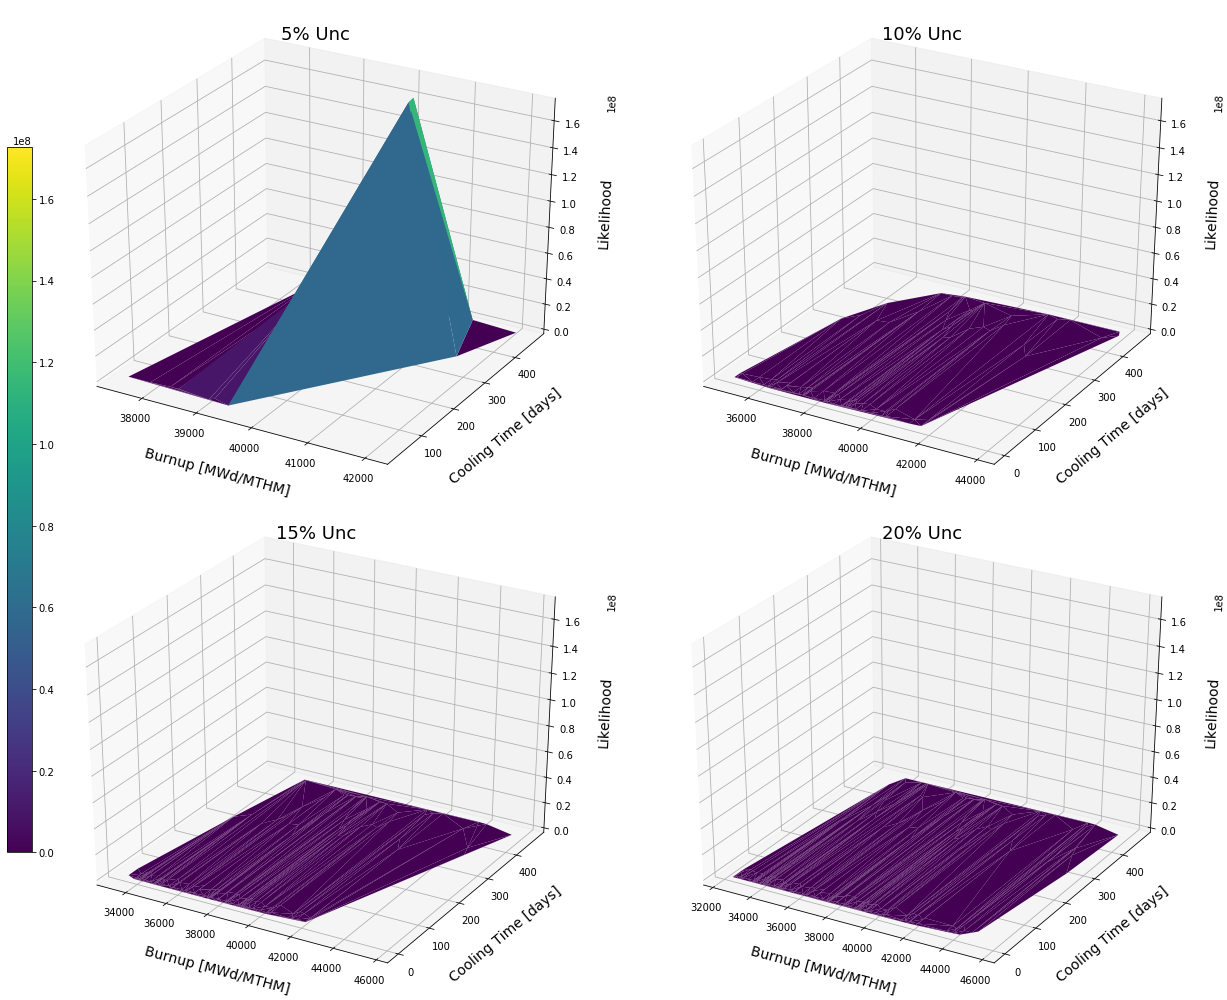

In [117]:
plotXY1 = fullXY.loc[fullXY[l1] > means[0]]
plotXY2 = fullXY.loc[fullXY[l2] > means[1]]
plotXY3 = fullXY.loc[fullXY[l3] > means[2]]
plotXY4 = fullXY.loc[fullXY[l4] > means[3]]
plots = [plotXY1, plotXY2, plotXY3, plotXY4]
plotme(plots, uncss, zname, vmin=min(meds), vmax=max(maxs))

# 2. Cont: Likelihood single plots

In [42]:
plotXY = fullXY

/home/opotowsky/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'edgecolor', 'linewidth'


<Figure size 432x288 with 0 Axes>

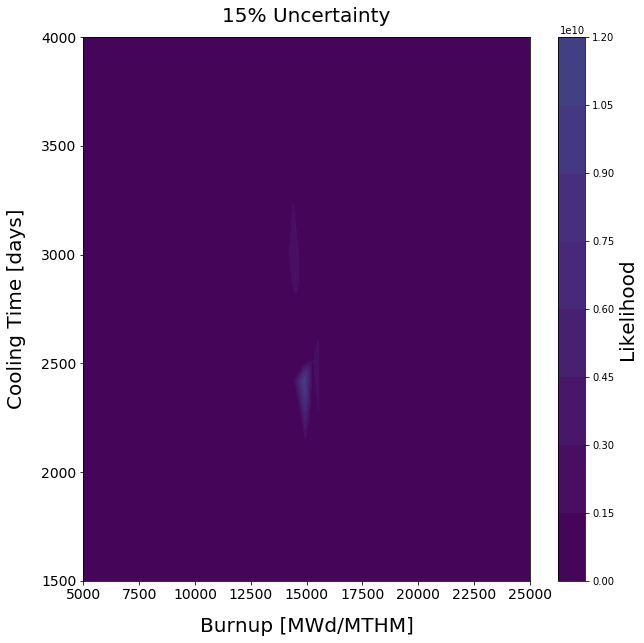

In [46]:
plt.clf()

vmin=0#meds[3]
vmax=maxs[2]

fig = plt.figure(figsize=(10, 10))
cmap = sns.cubehelix_palette(6, as_cmap=True)
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)
ax = fig.add_subplot(111)#, projection='3d')
x = plotXY['Burnup']
y = plotXY['CoolingTime']
triang = tri.Triangulation(x, y)

z = plotXY[l3]
ax.set_title(uncss[2], fontsize=20, pad=15)

surf = ax.tricontourf(triang, z, edgecolor='none', linewidth=0, antialiased=False, norm=norm, cmap=matplotlib.cm.viridis)#, shade=True)


ax.set_xlabel('Burnup [MWd/MTHM]', fontsize=20, labelpad=15)
ax.set_ylabel('Cooling Time [days]', fontsize=20, labelpad=15)
ax.set_xlim(5000, 25000)
ax.set_ylim(1500, 4000)

cbar = fig.colorbar(surf)
cbar.ax.set_ylabel('Likelihood', size=20)
ax.tick_params(labelsize=14)
plt.show()

#fig.savefig('../results/19jan2020_15nuc/graphs/lsurf_0.20unc.png', bbox_inches='tight', transparent=True)

# 3. Get LL Pred Results

In [178]:
ll1 = 'LogLikelihood_0.05'
ll2 = 'LogLikelihood_0.1'
ll3 = 'LogLikelihood_0.15'
ll4 = 'LogLikelihood_0.2'
lu1 = 'LLUncertainty_0.05'
lu2 = 'LLUncertainty_0.1'
lu3 = 'LLUncertainty_0.15'
lu4 = 'LLUncertainty_0.2'
lls = [ll1, ll2, ll3, ll4]
lus = [lu1, lu2, lu3, lu4]
uncs = ['5% Uncertainty', '10% Uncertainty', '15% Uncertainty', '20% Uncertainty']

In [149]:
fullXY.head()

,Burnup,CoolingTime,Enrichment,OrigenReactor,ReactorType,ba136,ba138,cs133,cs134,cs135,...,LLUncertainty_0.05,Likelihood0.1,LogLikelihood_0.1,LLUncertainty_0.1,Likelihood0.15,LogLikelihood_0.15,LLUncertainty_0.15,Likelihood0.2,LogLikelihood_0.2,LLUncertainty_0.2
1,2006.54,0.000839,0.53,ce14x14,pwr,0.000593,0.6109,0.5142,0.002411,0.1187,...,2.507794e+10,0.0,-6.276547e+10,1.253897e+10,0.0,-2.789577e+10,8.359314e+09,0.0,-1.569137e+10,6.269485e+09
2,2006.54,0.592485,0.53,ce14x14,pwr,0.000600,0.6114,0.5204,0.002411,0.1209,...,2.507794e+10,0.0,-6.276537e+10,1.253897e+10,0.0,-2.789572e+10,8.359314e+09,0.0,-1.569134e+10,6.269485e+09
3,2006.54,1.109213,0.53,ce14x14,pwr,0.000607,0.6114,0.5256,0.002410,0.1224,...,2.507794e+10,0.0,-6.276530e+10,1.253897e+10,0.0,-2.789569e+10,8.359314e+09,0.0,-1.569132e+10,6.269485e+09
4,2006.54,8.460400,0.53,ce14x14,pwr,0.000681,0.6114,0.5759,0.002394,0.1238,...,2.507794e+10,0.0,-6.276469e+10,1.253897e+10,0.0,-2.789542e+10,8.359314e+09,0.0,-1.569117e+10,6.269485e+09
5,2006.54,38.415629,0.53,ce14x14,pwr,0.000806,0.6114,0.6069,0.002329,0.1238,...,2.507794e+10,0.0,-6.276476e+10,1.253897e+10,0.0,-2.789545e+10,8.359314e+09,0.0,-1.569119e+10,6.269486e+09


## Reactor Prediction

In [174]:
data = {}
idx = {}
for ll, lu in zip(lls, lus):
    max_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].max()
    idx_pwr = fullXY[ll].loc[fullXY['ReactorType'] == 'pwr'].idxmax()
    unc_pwr = float(fullXY[lu].loc[fullXY.index == idx_pwr])
    max_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].max()
    idx_bwr = fullXY[ll].loc[fullXY['ReactorType'] == 'bwr'].idxmax()
    unc_bwr = float(fullXY[lu].loc[fullXY.index == idx_bwr])
    max_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].max()
    idx_phwr = fullXY[ll].loc[fullXY['ReactorType'] == 'phwr'].idxmax()
    unc_phwr = float(fullXY[lu].loc[fullXY.index == idx_phwr])
    data[ll] = [max_pwr, max_bwr, max_phwr]
    data[lu] = [unc_pwr, unc_bwr, unc_phwr]
    idx[ll] = [idx_pwr, idx_bwr, idx_phwr]
rxtr = pd.DataFrame(data, columns=[ll1, lu1, ll2, lu2, ll3, lu3, ll4, lu4], index=['pwr', 'bwr', 'phwr'])
rxtr

,LogLikelihood_0.05,LLUncertainty_0.05,LogLikelihood_0.1,LLUncertainty_0.1,LogLikelihood_0.15,LLUncertainty_0.15,LogLikelihood_0.2,LLUncertainty_0.2
pwr,18.967565,3.254686,10.520009,1.627343,5.024011,1.508366,0.943795,1.131275
bwr,2.344970,8.902489,6.566396,4.451245,3.208129,3.008143,-0.083764,2.718742
phwr,-451595.105989,37524.646638,-112875.317334,18762.323319,-50153.587113,12508.215546,-28203.168076,9381.161659


In [175]:
idx

{'LogLikelihood_0.05': [2847, 21427, 24790],
 'LogLikelihood_0.1': [2847, 21427, 24790],
 'LogLikelihood_0.15': [3915, 21418, 24790],
 'LogLikelihood_0.2': [3915, 14107, 24790]}

In [182]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'Burnup']])

LogLikelihood_0.05
     ReactorType    Burnup
2847         pwr  40412.05
      ReactorType    Burnup
21427         bwr  37521.68
      ReactorType    Burnup
24790        phwr  13678.58
LogLikelihood_0.1
     ReactorType    Burnup
2847         pwr  40412.05
      ReactorType    Burnup
21427         bwr  37521.68
      ReactorType    Burnup
24790        phwr  13678.58
LogLikelihood_0.15
     ReactorType    Burnup
3915         pwr  39013.38
      ReactorType    Burnup
21418         bwr  37361.88
      ReactorType    Burnup
24790        phwr  13678.58
LogLikelihood_0.2
     ReactorType    Burnup
3915         pwr  39013.38
      ReactorType    Burnup
14107         bwr  36727.11
      ReactorType    Burnup
24790        phwr  13678.58


In [183]:
for ll in lls:
    print(ll)
    for i, index in enumerate(idx[ll]):
        print(fullXY.loc[fullXY.index == idx[ll][i], ['ReactorType', 'CoolingTime']])

LogLikelihood_0.05
     ReactorType  CoolingTime
2847         pwr   392.313045
      ReactorType  CoolingTime
21427         bwr    34.458875
      ReactorType  CoolingTime
24790        phwr     5.662128
LogLikelihood_0.1
     ReactorType  CoolingTime
2847         pwr   392.313045
      ReactorType  CoolingTime
21427         bwr    34.458875
      ReactorType  CoolingTime
24790        phwr     5.662128
LogLikelihood_0.15
     ReactorType  CoolingTime
3915         pwr   343.237299
      ReactorType  CoolingTime
21418         bwr    34.458875
      ReactorType  CoolingTime
24790        phwr     5.662128
LogLikelihood_0.2
     ReactorType  CoolingTime
3915         pwr   343.237299
      ReactorType  CoolingTime
14107         bwr    37.125682
      ReactorType  CoolingTime
24790        phwr     5.662128
